In [ ]:
! pip install -q bitsandbytes datasets accelerate loralib
! pip install -q git+https://github.com/huggingface/transformers.git@main git+https://github.com/huggingface/peft.git
! pip install optimum auto-gptq
! pip install seaborn
! pip install wandb
! pip install flash-attn --no-build-isolation

In [1]:
import transformers, torch

In [2]:
import wandb
wandb.login()
wandb.init(project="OpsHarmonySentinel")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: imthegodfather. Use `wandb login --relogin` to force relogin


In [3]:
from huggingface_hub import notebook_login
notebook_login()

In [3]:
import os
PROJECT_DIR_PATH = ''
OUTPUT_PATH = os.path.join(PROJECT_DIR_PATH, 'model', 'files')

In [17]:
DEVICE = 'cuda'

BASELINE_MODEL_NAME = 'HuggingFaceH4/zephyr-7b-beta'
PROJECT_NAME = 'OpsHarmonySentinel'
HUGGING_FACE_REPO_NAME = f'imTheGodFather/{PROJECT_NAME}'
HUGGING_FACE_MERGED_REPO_NAME = f'{HUGGING_FACE_REPO_NAME}_merged'
HUGGING_FACE_GPTQ_REPO_NAME = f'{HUGGING_FACE_REPO_NAME}_gptq'

Dataset

In [16]:
from datasets import load_dataset
ds = load_dataset('birgermoell/open_assistant_dataset')

In [17]:
import pandas as pd
df = ds['train'].to_pandas()

In [18]:
df.head(3)

,text,meta
0,User: User: Where did the first transistor com...,{'source': ''}
1,User: User: How can I sync my cell phone with ...,{'source': ''}
2,User: User: Explain the concept of blockchain ...,{'source': ''}


In [13]:
import pandas as pd

train_path = "/home/tranquility/documents/OpsHarmonySentinel/data/train.csv"
df = pd.read_csv(train_path)

In [18]:
# Get tokenizer
import transformers
tokenizer = transformers.AutoTokenizer.from_pretrained(BASELINE_MODEL_NAME,
                                                       padding_side='left',
                                                       add_eos_token=True
                                                       )
tokenizer.pad_token = tokenizer.eos_token

tokenizer_config.json: 100%|██████████| 1.43k/1.43k [00:00<00:00, 227kB/s]
tokenizer.model: 100%|██████████| 493k/493k [00:00<00:00, 1.11MB/s]
tokenizer.json: 100%|██████████| 1.80M/1.80M [00:01<00:00, 1.21MB/s]
added_tokens.json: 100%|██████████| 42.0/42.0 [00:00<00:00, 20.2kB/s]
special_tokens_map.json: 100%|██████████| 168/168 [00:00<00:00, 154kB/s]


In [19]:
def text_to_dialogue(text):
    return [sentence.replace('User:', '').replace('Chip:', '').strip() for sentence in text.split('Assistant:')]

def dialogue_to_chat(dialogue):
    out = [{'role': 'system', 'content': 'You are a friendly chatbot assistant made by HEAL. You are an expert in ITOps, servers, applications and all other related domains.'}]
    # for idx, message in enumerate(dialogue):
    #     role = 'user' if idx%2==0 else 'assistant'
    #     out.append({'role': role, 'content': message})
    input = f"Investigate and provide root cause for the following incident - {dialogue['incident']}"
    out.append({'role': 'user', 'content': input})
    out.append({'role': 'assistant', 'content': dialogue['root_cause']})
    return out

def chat_to_input(chat):
    return tokenizer.apply_chat_template(chat, tokenize=False)

def process_example(example):
    # out = text_to_dialogue(example)
    out = dialogue_to_chat(example)
    out = chat_to_input(out)
    return out

In [21]:
example = df['text'].iloc[12312]

print(example)
print()
print(process_example(example))

User: User: Does anyone have any tips on saving money?
Assistant: Chip: One tip for saving money is to create a budget and stick to it. Make sure you track your expenses and put aside money for savings each month. Additionally, research deals and discounts online before you make a purchase, and take advantage of any coupons or promotions. You can also look for alternatives to expensive items, and consider cooking meals at home rather than eating out. Finally, try to pay down any debt and reduce frivolous spending.

<|system|>
You are a friendly chatbot assistant.</s>
<|user|>
Does anyone have any tips on saving money?</s>
<|assistant|>
One tip for saving money is to create a budget and stick to it. Make sure you track your expenses and put aside money for savings each month. Additionally, research deals and discounts online before you make a purchase, and take advantage of any coupons or promotions. You can also look for alternatives to expensive items, and consider cooking meals at ho

In [20]:
data = [process_example(row) for idx, row in df.iterrows()]

In [23]:
print(data[0])

<|system|>
You are a friendly chatbot assistant made by HEAL. You are an expert in ITOps, servers, applications and all other related domains.</s>
<|user|>
Investigate and provide root cause for the following incident - [
    {
        "incidentId": "E-21-2-745-2100155821",
        "incidentStartTime": "04/01/2023 10:35",
        "probabilityScore": 0.89,
        "anomalyId": "AE-21-7524-3-J-S-ALL-38435897",
        "anomalyTimestamp": "04/01/2023 10:35",
        "applicationId": "java-webapp",
        "instanceId": "weblogic-server-001",
        "serviceId": "weblogic-service",
        "kpi": "HEAP_MEMORY_USAGE",
        "value": 95.6,
        "thresholds": {"Upper": 90.0, "Lower": 0.0},
        "violationType": "Greater Than",
        "tags": [
            {"kpi": "HeapMemory"},
            {"kpiCategory": "Memory"},
            {"kpiType:": "JVM"},
            {"anomalyLevel": "INSTANCE"},
            {"severity": "SEVERE"}
        ],
        "components": [
            {"operatingS

In [ ]:
data = list(map(process_example, df['text']))

In [23]:
from random import shuffle
shuffle(data)

In [24]:
tokenized_data = list(map(tokenizer, data))

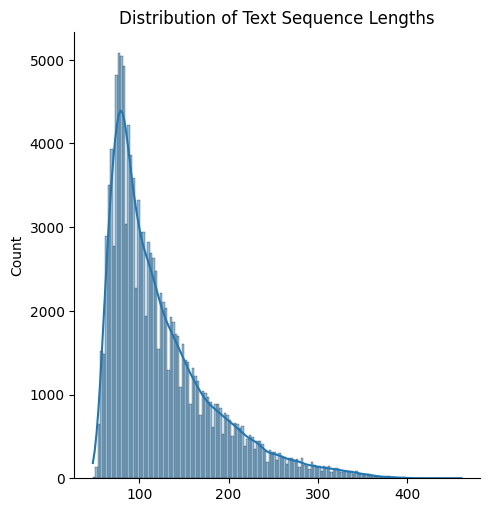

In [15]:
# Plot sequence Lengths
import seaborn as sns

input_lengths = [len(x['input_ids']) for x in tokenized_data]
sns.displot(input_lengths, kde=True).set(title='Distribution of Text Sequence Lengths')

In [25]:
split_idx = int(.99 * len(data))
train_data, val_data = tokenized_data[:split_idx], tokenized_data[split_idx:]

Finetune

In [5]:
# Get quantized model
model = transformers.AutoModelForCausalLM.from_pretrained(BASELINE_MODEL_NAME,
                                                          load_in_8bit=True,     # call for the 8 bit bnb quantized version
                                                          device_map='auto'
                                                          )

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

In [6]:
# Get tokenizer
tokenizer = transformers.AutoTokenizer.from_pretrained(BASELINE_MODEL_NAME,
                                                       padding_side='left',
                                                       add_eos_token=True
                                                       )
tokenizer.pad_token = tokenizer.eos_token

In [7]:
model

MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(32000, 4096, padding_idx=2)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralAttention(
          (q_proj): Linear8bitLt(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear8bitLt(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear8bitLt(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear8bitLt(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): MistralRotaryEmbedding()
        )
        (mlp): MistralMLP(
          (gate_proj): Linear8bitLt(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear8bitLt(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear8bitLt(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): MistralRMSNorm()
        (post_attention_layernorm): Mistr

In [8]:
# Set PEFT adapter config (16:32)
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training

config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["q_proj", "v_proj"],                             # Apply to "q_proj", "v_proj" layers of attention (as suggested by paper)
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM")

In [9]:
# stabilize output layer and layernorms
model = prepare_model_for_kbit_training(model, 8)

In [10]:
# Set PEFT adapter on model (Last step)
model = get_peft_model(model, config)

In [11]:
# Set Hyperparameters
MAXLEN=512
BATCH_SIZE=6
GRAD_ACC=4
WARMUP=100
STEPS=10
OPTIMIZER='paged_adamw_8bit' # save memory
LR=4e-5                      # slightly smaller than pretraining lr | and close to LoRA standard

In [12]:
# Setup Callbacks
early_stop = transformers.EarlyStoppingCallback(10, 1.15)

In [13]:
# Set training config
training_config = transformers.TrainingArguments(per_device_train_batch_size=BATCH_SIZE,
                                                 gradient_accumulation_steps=GRAD_ACC,
                                                 warmup_steps=WARMUP,
                                                 max_steps=STEPS,
                                                 optim=OPTIMIZER,
                                                 learning_rate=LR,
                                                 fp16=True,            # consider compatibility when using bf16
                                                 logging_steps=1,
                                                 output_dir=OUTPUT_PATH,
                                                 report_to='wandb',
                                                 # earlyStopping callback requirements
                                                 load_best_model_at_end=True,
                                                 evaluation_strategy='steps',
                                                 metric_for_best_model='eval_loss',
                                                 greater_is_better=False,
                                                 eval_steps=10,
                                                 save_steps=10,
                                                 save_total_limit=2,
                                                 )

In [14]:
# Set collator
data_collator = transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False)

In [26]:
# Setup trainer
trainer = transformers.Trainer(model=model,
                               train_dataset=train_data,
                               eval_dataset=val_data,
                               data_collator=data_collator,
                               args=training_config,
                               callbacks=[early_stop],
                              )

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [ ]:
model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

In [ ]:
# model.push_to_hub(HUGGING_FACE_REPO_NAME)
# tokenizer.push_to_hub(HUGGING_FACE_REPO_NAME)

Merge Adapters to dequantized model

In [ ]:
# # Try Model with Lora adapter
# messages = [
#     {"role": "system", "content": "You are a friendly chatbot assistant."},
#     {"role": "user", "content": "Hello, what are your limitations as a seven billion parameters nlp model ?"},
# ]
#
# gen_input = tokenizer.apply_chat_template(messages, return_tensors="pt").to('cuda')
# gen_output = model.generate(input_ids=gen_input, max_new_tokens=512, do_sample=True)
# print(tokenizer.decode(gen_output[0], skip_special_tokens=True))
# # timeit : 12.6 s ± 3.39 s per loop (mean ± std. dev. of 7 runs, 1 loop each)

In [ ]:
# Get peft config
from peft import PeftConfig
config = PeftConfig.from_pretrained(HUGGING_FACE_REPO_NAME)

In [ ]:
# Get base model
model = transformers.AutoModelForCausalLM.from_pretrained(config.base_model_name_or_path,
                                                          torch_dtype=torch.float16, # GPTQ quantization requires fp16
                                                          return_dict=True,
                                                          )

In [ ]:
# Load the Lora model
from peft import PeftModel
model = PeftModel.from_pretrained(model, HUGGING_FACE_REPO_NAME)

In [ ]:
# Get tokenizer
tokenizer = transformers.AutoTokenizer.from_pretrained(config.base_model_name_or_path,
                                                       padding_side='left',
                                                       add_eos_token=True
                                                       )
tokenizer.pad_token = tokenizer.eos_token

In [ ]:
merged_model = model.merge_and_unload()

In [ ]:
# merged_model.push_to_hub(HUGGING_FACE_MERGED_REPO_NAME)
# tokenizer.push_to_hub(HUGGING_FACE_MERGED_REPO_NAME)

Quantize with GPTQ

In [ ]:
OFFLOAD_PATH = os.path.join(PROJECT_DIR_PATH, 'offload')

In [28]:
torch.cuda.empty_cache()

: 

In [ ]:
# Get tokenizer
import transformers
tokenizer = transformers.AutoTokenizer.from_pretrained(HUGGING_FACE_REPO_NAME,
                                                       padding_side='left',
                                                       add_eos_token=True
                                                       )
tokenizer.pad_token = tokenizer.eos_token

In [ ]:
quantization_config = transformers.GPTQConfig(bits=4,
                                              group_size=128,
                                              desc_act=False,
#                                              dataset=train_data,
                                              dataset=data[:660],
                                              tokenizer=tokenizer)

In [ ]:
# Quantize model
q_model = transformers.AutoModelForCausalLM.from_pretrained(HUGGING_FACE_MERGED_REPO_NAME,
                                                            quantization_config=quantization_config,
                                                            torch_dtype=torch.float16,
                                                            device_map="auto",
#                                                            offload_folder=OFFLOAD_PATH
                                                            )

In [ ]:
# Push to HF hub
q_model.push_to_hub(HUGGING_FACE_GPTQ_REPO_NAME)
tokenizer.push_to_hub(HUGGING_FACE_GPTQ_REPO_NAME)

Inference

In [ ]:
import transformers, torch

In [ ]:
# Get model
model = transformers.AutoModelForCausalLM.from_pretrained(HUGGING_FACE_MERGED_REPO_NAME,
                                                          device_map="auto",
                                                          torch_dtype=torch.bfloat16,
                                                          use_flash_attention_2=True,
#                                                          low_cpu_mem_usage=True,
                                                         )

In [ ]:
# Get tokenizer
tokenizer = transformers.AutoTokenizer.from_pretrained(HUGGING_FACE_MERGED_REPO_NAME, padding_side='left')

In [ ]:
# Try GPTQ finetuned model
messages = [
    {"role": "system", "content": "You are a friendly chatbot assistant."},
    {"role": "user", "content": "Hello, what are the keys things to keep in mind during a job interview ?"},]
gen_input = tokenizer.apply_chat_template(messages, return_tensors="pt").to('cuda')

gen_output = model.generate(input_ids=gen_input,
                            max_new_tokens=256,
                            do_sample=True,
                            temperature=0.7,
                            top_k=50,
                            top_p=0.95,
                            repetition_penalty=1.1)
out = tokenizer.decode(gen_output[0], skip_special_tokens=True)
print(out)